In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import soundfile as sf

In [34]:
def mel(signal: np.ndarray, sample_rate: int, window_len, step_len, n_fft, mels, fmin, fmax, alpha=0.97, window='hann'):
    if window == 'hann':
        window_func = np.hanning
    elif window == 'hamming':
        window_func = np.hamming
    elif window == 'blackman':
        window_func = np.blackman
    else:
        raise NotImplemented("Window type not known")
    
    signal = np.append(signal[0], signal[1:] - alpha * signal[:-1])
    
    frames_cnt = (len(signal) - window_len) // step_len + 1
    frames = np.zeros((frames_cnt, window_len))
    for i in range(frames_cnt):
        frames[i, :] = signal[i * step_len : i * step_len + window_len] * window_func(window_len)
    if window_len < n_fft:
        frames = np.hstack((frames, np.zeros((frames_cnt, n_fft - window_len))))
    
    stft = np.fft.rfft(frames, n=n_fft)
    stft_power = np.abs(stft) ** 2 / n_fft

    mel_to_hz = lambda mel: 700 * (10 ** (mel / 2595) - 1)
    hz_to_mel = lambda hz: 2595 * np.log10(1 + hz / 700)

    mel_points = np.linspace(hz_to_mel(fmin), hz_to_mel(fmax), mels + 2)
    hz_points = mel_to_hz(mel_points)
    bins = np.floor(n_fft * hz_points / sample_rate).astype(int)
    
    fbank = np.zeros((mels, n_fft // 2 + 1))
    for i in range(1, mels + 1):
        f_i0, f_i, f_i1 = bins[i - 1], bins[i], bins[i + 1]
        for f_k in range(f_i0, f_i):
            fbank[i - 1, f_k] = (f_k - f_i0) / (f_i - f_i0)
        for f_k in range(f_i, f_i1):
            fbank[i - 1, f_k] = (f_i1 - f_k) / (f_i1 - f_i)

    mel_spectrogram = np.dot(stft_power, fbank.T)
    mel_spectrogram = np.where(mel_spectrogram == 0, np.finfo(float).eps, mel_spectrogram)
    mel_spectrogram = 10 * np.log10(mel_spectrogram)
    return mel_spectrogram
                            
    


## Визуализация

Взял какую-то рандомную запись голоса с каггла.

In [41]:
wav_path = "data/harvard.wav"
n_fft = 2048
mels = 80
fmin = 20
fmax = 8000

signal, sr = sf.read(wav_path)
signal = np.mean(signal, axis=1)

In [42]:
print('Частота дискретизации:', sr)

window_len = int(sr * 0.025)
step_len = int(sr * 0.01)

Частота дискретизации: 44100


<Axes: >

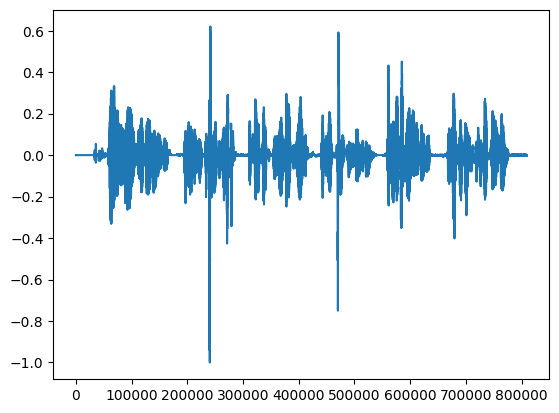

In [43]:
sns.lineplot(signal)

In [44]:
mel_spec = mel(
    signal=signal,
    sample_rate=sr,
    window_len=window_len,
    step_len=step_len,
    n_fft=n_fft,
    mels=mels,
    fmin=fmin,
    fmax=fmax,
)

Text(0.5, 1.0, 'Mel Spectrogram')

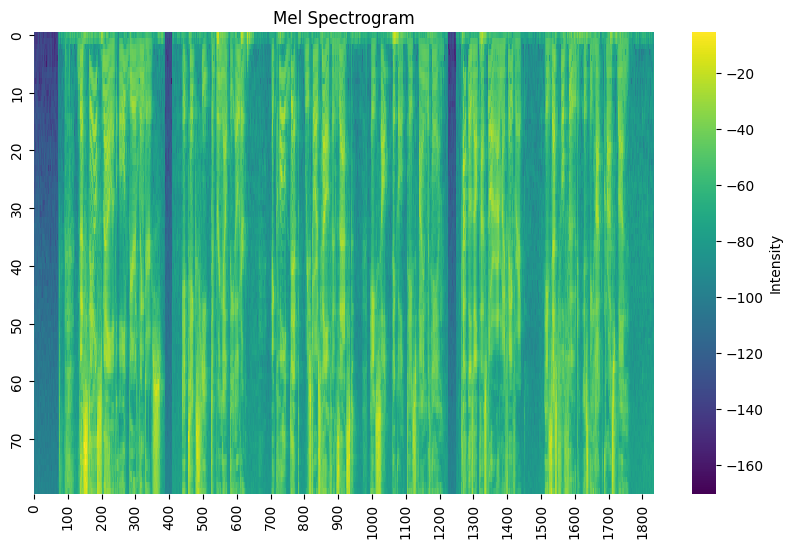

In [45]:
plt.figure(figsize=(10, 6))

sns.heatmap(mel_spec.T, cmap='viridis', cbar_kws={'label': 'Intensity'}, xticklabels=100, yticklabels=10)
plt.title('Mel Spectrogram')